In [15]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import glob
from tqdm import tqdm
from scipy.special import logsumexp
import os 
import pandas as pd
from functools import reduce
import operator


import sys
sys.path.append('../')
from populations import bbh_models, gw_obs
import populations.bbh_models as read_models
from populations.bbh_models import read_hdf5
from sample import sample

In [42]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
channels =['CE', 'CHE', 'GC', 'NSC', 'SMT']
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = "/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/simulated_events_processed/2_chi02"
np.random.seed(12)
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', 'p_theta_jcb')

#model_names, flow = read_models.get_models(file_path, channels, params, use_flows=True, use_unityweights=False, device='cpu',\
#     no_bins=[5,4,4,5,4], sensitivity='midhighlatelow')
model_names, KDE_models = read_models.get_models(file_path, channels, params, use_flows=False, device='cpu', use_unityweights=False, sensitivity='midhighlatelow')

 89%|████████▉ | 32/36 [00:21<00:01,  2.49it/s]

In [ ]:
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)
def setInDict(dataDict, mapList, value):
    getFromDict(dataDict, mapList[:-1])[mapList[-1]] = value

model_names.sort()
hyperparams = sorted(list(set([x.split('/', 1)[1] for x in model_names])))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])

hyperparam_dict  = {}
hyperidx=0

while hyperidx < Nhyper:
    hyperidx_with_Nhyper = np.argwhere(np.asarray([len(x.split('/')) for x in hyperparams])>hyperidx).flatten()
    hyperparams_at_level = sorted(set([x.split('/')[hyperidx] for x in np.asarray(hyperparams)[hyperidx_with_Nhyper]]))
    hyperparam_dict[hyperidx] = hyperparams_at_level
    hyperidx += 1

all_models_at_deepest = all([len(x.split('/')[1:])==Nhyper for x in model_names])
while all_models_at_deepest==False:
    # loop until all models have the same length
    for model in model_names:
        # See number of hyperparameters in model, subtract one for channel
        Nhyper_in_model = len(model.split('/'))-1
        kde_hold = getFromDict(KDE_models, model.split('/'))
        # loop until this model has all the hyperparam levels as well
        while Nhyper_in_model < Nhyper:
            # remove kde model from old level
            setInDict(KDE_models, model.split('/'), {})
            model_names.remove(model)
            for new_hyperparam in hyperparam_dict[Nhyper_in_model]:
                # copy the same kde model for the higher hyperparam level
                new_kde = deepcopy(kde_hold)
                new_level = model.split('/') + [new_hyperparam]
                setInDict(KDE_models, new_level, new_kde)
                # add new model name
                model_names.append(model+'/'+new_hyperparam)
            Nhyper_in_model += 1
        model_names.sort()
    # see if all models are at deepest level else repeat
    all_models_at_deepest = all([len(x.split('/')[1:])==Nhyper for x in model_names])

In [4]:
submodels_dict = {0: {0: 'chi00', 1: 'chi01', 2: 'chi02', 3: 'chi05'}, 1: {0: 'alpha02', 1: 'alpha05', 2: 'alpha10', 3: 'alpha20', 4: 'alpha50'}}
_concentration = np.ones(len(channels))

In [40]:
#varying beta_CE with KDE models
p_betaCE=np.zeros(20)
alpha=np.zeros(20)
chi_b_id = 2
alpha_id = 2

for i, beta_CE in enumerate(np.linspace(0.05,0.95,20)):
    sampler_hyperposts = [2., 2., beta_CE,(1-beta_CE)/5,(1-beta_CE)/5,(1-beta_CE)/5]
    betas = np.concatenate((sampler_hyperposts[2:], [1-np.sum(sampler_hyperposts[2:])]))
    p_betaCE[i] = sample.lnpost(sampler_hyperposts, obsdata, KDE_models, submodels_dict, channels, _concentration, False, 990903, p_theta)

    alpha[i]=0.
    for cidx, channel in enumerate(channels):
        KDE = KDE_models[channel]
        beta = betas[cidx]
        alpha[i] += beta * KDE[submodels_dict[0][chi_b_id]][submodels_dict[1][alpha_id]].alpha

"for a in [0.2,0.5,1.,2.,5.]:\n    ax[0].vlines(a, 150, 300, color='black', alpha=0.5)\n    ax[1].vlines(a, 350, 500, color='black', alpha=0.5)\n    ax[2].vlines(a, -230, -180, color='black', alpha=0.5)"

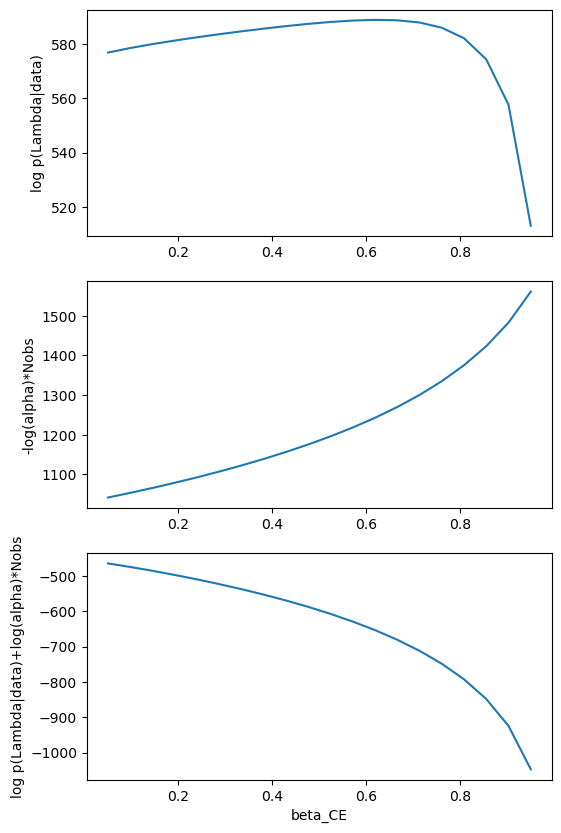

In [41]:
plt.rcParams["figure.figsize"] = (6,10)
fig,ax= plt.subplots(3,1)
ax[0].plot(np.linspace(0.05,0.95,20),p_betaCE)
ax[1].plot(np.linspace(0.05,0.95,20),-np.log(alpha)*obsdata.shape[0])
ax[2].plot(np.linspace(0.05,0.95,20),p_betaCE+(np.log(alpha)*obsdata.shape[0]))

ax[0].set_ylabel('log p(Lambda|data)')
ax[1].set_ylabel('-log(alpha)*Nobs')
ax[2].set_ylabel('log p(Lambda|data)+log(alpha)*Nobs')
ax[2].set_xlabel('beta_CE')

"""for a in [0.2,0.5,1.,2.,5.]:
    ax[0].vlines(a, 150, 300, color='black', alpha=0.5)
    ax[1].vlines(a, 350, 500, color='black', alpha=0.5)
    ax[2].vlines(a, -230, -180, color='black', alpha=0.5)"""

In [39]:
models = [f'{channel}/chi02/alpha10' for channel in channels]
for model in models:
    getFromDict(KDE_models, model.split('/')).freeze(obsdata, 990903, data_pdf=p_theta, multiproc=False)


100%|██████████| 250/250 [00:52<00:00,  4.79it/s]


In [27]:
getFromDict(KDE_models, model.split('/')).cached_values

array([1.00918351e-06, 1.00917950e-06, 1.00917950e-06, 9.77031148e-03,
       5.26949606e-01, 1.00972239e-06, 1.92839279e-05, 1.00917950e-06,
       1.00917950e-06, 3.02408342e-02, 1.00917950e-06, 1.00917950e-06,
       1.00917950e-06, 1.00918284e-06, 6.03702839e-01, 1.00917951e-06,
       2.84466582e-03, 1.00917950e-06, 7.09202894e-03, 1.00918576e-06,
       5.49928197e-04, 1.00917950e-06, 2.52061364e-05, 1.00917968e-06,
       1.00917950e-06, 3.79451371e-01, 3.63428984e-01, 1.00917950e-06,
       3.36974956e+00, 1.00917950e-06, 4.72414663e-01, 1.00917950e-06,
       6.39833460e+00, 2.95636296e+00, 1.33609804e-02, 1.00917950e-06,
       1.04018045e+00, 1.01119839e-06, 5.44697537e-03, 1.00917950e-06,
       1.00917952e-06, 3.22922354e-05, 1.57436112e-04, 1.00917950e-06,
       1.00923555e-06, 2.12013048e+00, 1.01054899e-06, 1.00917950e-06,
       3.73070778e+00, 1.00917950e-06, 7.11338105e-01, 2.65314160e-02,
       8.55744989e-05, 7.17436286e-02, 1.00917950e-06, 8.49711232e-01,
      

In [28]:
beta_CE=0.05
sampler_hyperposts = [2.0, 2.0, beta_CE,(1-beta_CE)/5,(1-beta_CE)/5,(1-beta_CE)/5]
betas = np.concatenate((sampler_hyperposts[2:], [1-np.sum(sampler_hyperposts[2:])]))
p_betaCE = sample.lnpost(sampler_hyperposts, obsdata, KDE_models, submodels_dict, channels, _concentration, False, 990903, p_theta)

In [7]:
KDE_models

{'CE': {'chi00': {'alpha02': <populations.KDEModel at 0x7fca6983ddc0>,
   'alpha05': <populations.KDEModel at 0x7fca7d231f10>,
   'alpha10': <populations.KDEModel at 0x7fca6984ccd0>,
   'alpha20': <populations.KDEModel at 0x7fca69858af0>,
   'alpha50': <populations.KDEModel at 0x7fca7d238100>},
  'chi01': {'alpha02': <populations.KDEModel at 0x7fca7d2537f0>,
   'alpha05': <populations.KDEModel at 0x7fca7d2535b0>,
   'alpha10': <populations.KDEModel at 0x7fca7d253f10>,
   'alpha20': <populations.KDEModel at 0x7fca69858850>,
   'alpha50': <populations.KDEModel at 0x7fca7d25dd60>},
  'chi02': {'alpha02': <populations.KDEModel at 0x7fca7d25dcd0>,
   'alpha05': <populations.KDEModel at 0x7fca7d23aaf0>,
   'alpha10': <populations.KDEModel at 0x7fca7d2645b0>,
   'alpha20': <populations.KDEModel at 0x7fca7d26d880>,
   'alpha50': <populations.KDEModel at 0x7fca7d26d190>},
  'chi05': {'alpha02': <populations.KDEModel at 0x7fca7d253430>,
   'alpha05': <populations.KDEModel at 0x7fca5a6c7100>,
   